In [31]:
import scipy.optimize
from qutip import *
from itertools import combinations,product
import numpy as np
from functools import partial
import matplotlib
from matplotlib import pyplot as plt
from math import sqrt
from multiprocessing import Pool
from tqdm import tqdm
font = {'size'   : 17}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"]= 7, 4
# plt.rcParams['figure.dpi'] = 60
matplotlib.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True

### Non-interacting probability distribution

$$
G(\omega) = \frac{1}{\omega - \epsilon_d - \Sigma_0 + i\Gamma}
$$

At $\Sigma = -\epsilon_d$, this becomes
$$
G(\omega) = \frac{1}{\omega + i\Gamma} \implies \rho_0 = \frac{1}{\pi} \frac{\Gamma^2}{\omega^2 + \Gamma^2}
$$

In [32]:
def get_H0_nu(w_range, gamma, sigma_0, ed, U, n):

    def func(bnu, x):
        sum = 0
        for b in combinations(bnu, n-1):
            prod = 1
            for bi in b:
                prod *= (x-bi)
            sum += prod
        return sum

    while True:
        try:
            rho = (1/np.pi)*gamma**2/(gamma**2 + (w_range - ed - sigma_0)**2)
            bnu = np.random.choice(w_range, size=n, replace=False, p=rho/sum(rho))
            func_partial = partial(func, bnu)
            Ek_nu = scipy.optimize.broyden1(func_partial, bnu, f_tol=1e-10)
            break
        except:
            continue
    Vk_nu = []
    for Ek in Ek_nu:
        Vk_nu.append(0)
        for b in combinations(bnu, n-1):
            prod = 1
            for bi in b:
                prod *= (Ek-bi)**2
            Vk_nu[-1] += prod
        Vk_nu[-1] = sqrt(n*Vk_nu[-1])

    e0_nu = np.mean(bnu)
    U_nu = U
    ed_nu = e0_nu - sigma_0
    return e0_nu, Ek_nu, Vk_nu, ed_nu, U_nu

In [33]:
def imp_energy(Ek_0, V, ed, U):
    H = 0
    dim = len(Ek_0)
    H += ed*tensor([create(2)*destroy(2), identity(2)] + [identity(2)]*2*dim)
    H += ed*tensor([identity(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    H += U*tensor([create(2)*destroy(2), create(2)*destroy(2)] + [identity(2)]*2*dim)
    return H


def kin_en(Ek_0, V, ed, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        H += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [create(2)*destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1)))
        H += Ek_0[i]*(tensor([identity(2)]*2 + [identity(2)]*2*i + [identity(2), create(2)*destroy(2)] + [identity(2)]*2*(dim - i - 1)))
    return H


def hyb(Ek_0, Vk, ed, U):
    H = 0
    dim = len(Ek_0)
    for i in range(dim):
        H += Vk[i] * tensor([create(2), identity(2)] + [identity(2)]*2*i + [destroy(2), identity(2)] + [identity(2)]*2*(dim - i - 1))
        H += Vk[i] * tensor([identity(2), create(2)] + [identity(2)]*2*i + [identity(2), destroy(2)] + [identity(2)]*2*(dim - i - 1))
        H -= Vk[i] * tensor([destroy(2), identity(2)] + [identity(2)]*2*i + [create(2), identity(2)] + [identity(2)]*2*(dim - i - 1)) 
        H -= Vk[i] * tensor([identity(2), destroy(2)] + [identity(2)]*2*i + [identity(2), create(2)] + [identity(2)]*2*(dim - i - 1))
    return H

In [50]:
def G_nu(w_range, E, X):
    delta = gamma
    E0 = min(E)
    Xgs = X[np.where(E == E0)]
    Gnu = 0*w_range
    for (En, Xn), X0 in product(zip(E,X), Xgs):
        c0_up = tensor([identity(2), destroy(2)] + [identity(2)]*(len(X0.dims[0])-2))
        C1 = X0.dag()*c0_up*Xn
        C1_sq = np.real((C1*C1.dag())[0][0][0])
        C2 = Xn.dag()*c0_up*X0
        C2_sq = np.real((C2*C2.dag())[0][0][0])
        x1 = w_range + E0 - En
        x2 = w_range + En - E0
        Gnu += (delta/np.pi)*(C1_sq/(x1**2 + delta**2) + C2_sq/(x2**2 + delta**2))
#         Gnu += C1_sq/x1 + C2_sq/x2
    return Gnu

def sigma_nu(w_range, Gnu, e0_nu, Vk_nu, Ek_nu, sigma_0):
    G_nu_0_inv = w_range - e0_nu  - sum([Vk**2/(w_range - Ek) for Vk, Ek in zip(Vk_nu, Ek_nu)])
    sigma_nu = G_nu_0_inv - 1/Gnu + sigma_0
    return sigma_nu

N=0: Diagonalisation done.
N=15: Diagonalisation done.
N=60: Diagonalisation done.
N=30: Diagonalisation done.
N=45: Diagonalisation done.
N=1: Diagonalisation done.
N=31: Diagonalisation done.
N=46: Diagonalisation done.
N=61: Diagonalisation done.
N=16: Diagonalisation done.
N=32: Diagonalisation done.
N=47: Diagonalisation done.
N=2: Diagonalisation done.
N=62: Diagonalisation done.
N=17: Diagonalisation done.
N=48: Diagonalisation done.
N=3: Diagonalisation done.
N=33: Diagonalisation done.
N=63: Diagonalisation done.
N=18: Diagonalisation done.
N=49: Diagonalisation done.
N=4: Diagonalisation done.
N=19: Diagonalisation done.
N=34: Diagonalisation done.
N=64: Diagonalisation done.
N=5: Diagonalisation done.
N=35: Diagonalisation done.
N=50: Diagonalisation done.
N=20: Diagonalisation done.
N=65: Diagonalisation done.
N=6: Diagonalisation done.
N=66: Diagonalisation done.
N=51: Diagonalisation done.
N=21: Diagonalisation done.
N=36: Diagonalisation done.
N=7: Diagonalisation done.


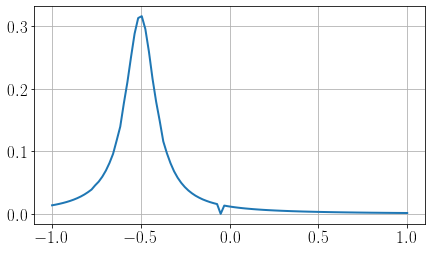

In [51]:
U = 1
ed = -U/2
sigma_0 = U/2   # this needs to be looked into
w_range = np.linspace(-1, 1, 100)
gamma = 0.1
N = 500
n = 4
sigma = w_range*0


def sample(i):
    e0_nu, Ek_nu, Vk_nu, ed_nu, U_nu = get_H0_nu(w_range, gamma, sigma_0, ed, U, n)
    H = 0
    H += kin_en(Ek_nu, Vk_nu, ed_nu, U_nu)
    H += imp_energy(Ek_nu, Vk_nu, ed_nu, U_nu)
    H += hyb(Ek_nu, Vk_nu, ed_nu, U_nu)
    H = 0.5 * (H + H.dag())
    E, X = H.eigenstates()
    print ("N={}: Diagonalisation done.".format(i))
    Gnu = G_nu(w_range, E, X)
    sigmanu = sigma_nu(w_range, Gnu, e0_nu, Vk_nu, Ek_nu, sigma_0)/N
    return sigmanu


# tqdm(Pool().map(get_rho_X, product(zip(E, X), X0_single, [False])), total=Z*len(E))
sigma = sum(Pool(5).map(sample, range(N)))/N
rho = (1/np.pi)*gamma**2/(gamma**2 + (w_range - ed - sigma)**2)
plt.plot(w_range, rho)
plt.show()